# Assignment 1

In this assignment, you are to implement a non-linear binary classifer.

## Setup

Suppose that we have training data in the following from:

- we have a collection of 2D vectors: $x: (n, 2)$, and their corresponding labels $y:(n,)$.

- Each row in $x$ is a 2D vector, $(x[i,0], x[i,1])$

- Each entry in $y$ is either 0 or 1.


## Review: Linear Classifier in 2D

A linear classifier can be thought of as a composition of linear line fitting followed by sigmoid activation.

$$ g(x) = x @ w + b $$
where $w:(2,1)$, so $x @ w: (n,1)$, and $b$ is a scalar.

Note $g$ is just a linear model with the standard model parameters $(w, b)$.

Now, we can add an _activation_ function:

$$ \sigma(x) = \frac{1}{1+e^{-x}} $$.

Together we get what we know as logistic regression, which has been discussed extensively in class.

$$ f_\mathrm{classifier2d}(x) = \sigma(g(x)) $$


## Review: Polynomial Line Fitting in 1D

Recall in polynomial line fitting, we first transform $x$ into its power series, which is used
as the input to linear model.

Specifically, we use the power series function to build
a vector from a scalar:

$$P_k : \mathbb{R}\to\mathbb{R^{k+1}} : x \mapsto (1, x, x^2, \dots, x^k)$$

The model is given as: $$f_\mathrm{poly1d}(x) = P_k(x)@w$$
with model parameter $w:(k+1, 1)$.


## Polynomial Classifier in 2D

In this assignment, we want to combine the two models to create a polynomial classifier in 2D.

---

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as pl

We load the data from the CSV file.

In [2]:
data = np.loadtxt('./training_2_categories.csv', delimiter=',', skiprows=1)
x_data = data[:, [0, 1]]
y_data = data[:, -1].astype(int)

## Work Unit 1: Plotting

Implement a function that will plot the two classes of data points on the 2D plane.

1. You are to use the `pl.scatter` function to plot the data points.  Each data point should have size set to 3.


2. You must plot the first category `y_data == 0` as red, and the second category `y_data == 1` as blue.

In [3]:
def plot_data():
    red_data = np.array([r for r in data if r[2].astype(int) == 0])
    blue_data = np.array([r for r in data if r[2].astype(int) == 1])
    marker_size = 3
    pl.scatter(red_data[:,0], red_data[:,1], marker_size, c='red');
    pl.scatter(blue_data[:,0], blue_data[:,1], marker_size, c='blue');

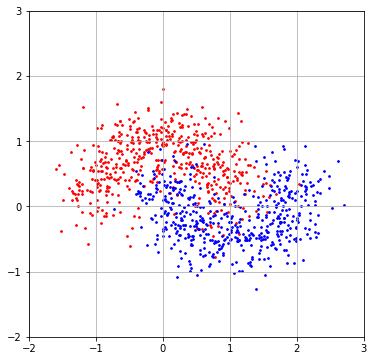

In [4]:
pl.figure(figsize=(6,6))
pl.xlim(-2, 3)
pl.ylim(-2, 3)
pl.grid()
plot_data()

We will perform nonlinear binary classification using a polynomial of degree k=3.

In [5]:
k = 3

## Work Unit 2: Computing power series

Implement the function that computes the power series (up to degree $k$) of a given batch of 2D vectors.

For each vector $x = (u, v)$, the power series is given
as a vector of length $2k+1$, given by:

$$P_k(x) = (1, u, u^2, u^3, v, v^2, v^3)$$

The implemented function `series` will accept a tensor of shape $(n, 2)$, and return a tensor of shape $(n, 7)$.

In [9]:
def series(x):
    result_list = []
    for item in x:
        result = []
        result.append(1.)
        for i in range(k):
            result.append(item[0] ** (i+1))
        for j in range(k):
            result.append(item[1] ** (j+1))
        result_list.append(result)
    return np.array(result_list)

In [10]:
series(x_data).shape

(1000, 7)

In [11]:
x_test = np.arange(6).reshape(3,2)
series(x_test)

array([[  1.,   0.,   0.,   0.,   1.,   1.,   1.],
       [  1.,   2.,   4.,   8.,   3.,   9.,  27.],
       [  1.,   4.,  16.,  64.,   5.,  25., 125.]])

The only model parameter is a tesnor of shape `(2*k+1, 1)`.

We will store all the model parameters in a list `theta`.  In this case, the list will only have one element.

We will also provide an initialization function that will reset the model parameter back to the initial value.

In [14]:
theta = [
    tf.Variable(np.ones((2*k+1, 1)))
]

def initialize_parameter():
    theta[0].assign(np.ones((2*k+1, 1)))
    return theta[0].numpy()

## Work Unit 3: The model

You are to implement the function which is the model.

The model is given as:

$$f(x) = \sigma(P(x) @ w)$$

Hint:

1. You can use `tf.keras.activations.sigmoid` to compute $\sigma$.


2. The input `x` has shape `(n, 2)`, and the power series
   `series(x)` has shape `(n, 7)`.


3. The model parameter has shape `(7, 1)`.  Therefore,
   `series(x) @ w` will have a shape of `(n, 1)`.


4. **You should get rid of the trivial axis with size 1**. This 
  can be done using `tf.squeeze`.

In [15]:
#
# The model with
# input x: (n, 2)
# output f(x): Tensor of shape (n,)
#
def f(x):
    w = theta[0]
    return tf.squeeze(tf.keras.activations.sigmoid(series(x) @ w))

In [16]:
type(f(x_data))

tensorflow.python.framework.ops.EagerTensor

In [17]:
initialize_parameter()
f(x_data)[:20].numpy().round(decimals=2)

array([1.  , 1.  , 0.81, 0.72, 0.78, 1.  , 0.99, 0.97, 0.76, 0.82, 0.35,
       0.85, 1.  , 0.89, 0.72, 0.95, 1.  , 0.95, 1.  , 0.95])

## Work Unit 4: Training Loop

Implement the training loop as a function `train(alpha, epochs)`
where `alpha` is the learning rate, and `epochs` is the total number of gradient updates.

**Requirement**:

1. You must use the built-in `tf.keras.losses.BinaryCrossEntropy()` as the loss function.


2. You must use the built-in `tf.keras.optimizers.Adam(learning_rate)` as the optimizer.  The `Adam` optimizer is much more numerically stable than the naive optimizer.


3. During the training loop, you are to print the epoch number (starting at 0) and the reduction in the loss function before the parameter update and after the parameter update.  Do this at 10 even spaced intervals.


4. At the end print the final loss.

In [27]:
def train(alpha, epochs):
    loss = tf.keras.losses.BinaryCrossentropy()
    optimizer = tf.keras.optimizers.Adam(alpha)
    # Training loop
    for i in range(epochs):
        with tf.GradientTape() as tape:
            L = loss(y_data, f(x_data))
        L0 = loss(y_data, f(x_data))
        grads = tape.gradient(L, theta)
        optimizer.apply_gradients(zip(grads, theta))
        if( i % (epochs // 10) == 0):
            L = loss(y_data, f(x_data))
            print("[%.2d] %.4f -> %.4f" % (i, L0, L))
    L_final = loss(y_data, f(x_data))
    print("[After %.2d epochs] %.4f" % (epochs, L_final))
    

The output of your code should be similar to:

```python
initialize_parameter()
train(1e-1, 200)

[0] 1.8571 -> 1.6959
[20] 0.3775 -> 0.3757
[40] 0.3300 -> 0.3275
[60] 0.2977 -> 0.2966
[80] 0.2818 -> 0.2812
[100] 0.2720 -> 0.2716
[120] 0.2648 -> 0.2645
[140] 0.2593 -> 0.2591
[160] 0.2550 -> 0.2548
[180] 0.2515 -> 0.2514
[After 200 epochs] 0.2487
```

In [28]:
initialize_parameter()
train(1e-1, 200)

[00] 1.8563 -> 1.6957
[20] 0.3775 -> 0.3757
[40] 0.3299 -> 0.3274
[60] 0.2976 -> 0.2965
[80] 0.2817 -> 0.2811
[100] 0.2719 -> 0.2715
[120] 0.2647 -> 0.2644
[140] 0.2592 -> 0.2590
[160] 0.2549 -> 0.2547
[180] 0.2514 -> 0.2513
[After 200 epochs] 0.2486


## Work Unit 5: Measuring accuracy

Implement a function, `evaluate`, which will perform the
prediction using the trained model.

The function:

```python
evaluate(x_data)
```

will use the trained model `f(...)` to determine the category
of each input vector in `x_data` using the following rule:

$$
\mathrm{category}(x) = \left\{\begin{array}{ll}
0 & \mathrm{if}\ f(x) < 0.5\\
1 & \mathrm{else}
\end{array}\right.
$$

The returned tensor `evaluate(x_data)` is a vector of 0s and 1s.

In [41]:
def evaluate(x_data):
    categries = [] 
    predicted_vals = f(x_data).numpy().round(decimals=2)
    for predicted_val in predicted_vals:
        if predicted_val < 0.5:
            categries.append(0)
        else:
            categries.append(1)
    return categries

In [42]:
#
# Compute the accuracy
#
n = x_data.shape[0]
y_pred = evaluate(x_data)
accuracy = np.sum(y_pred == y_data) / n

print("Accuracy is %.4f" % accuracy)

("Accuracy > 90% ?", accuracy > 0.90)

Accuracy is 0.9090


('Accuracy > 90% ?', True)

## Work Unit 6: Visualization

Implement a function that will apply the model over a 100$\times$100 meshgrid in 2D.

The function:

```python
z = f_meshgrid(xx, yy)
```

accepts two matrices corresponding to the x-coordinates and y-coordinates of the meshgrid.

$$ \mathrm{xx} : (100, 100)$$
$$ \mathrm{yy} : (100, 100)$$

The returned value $z$ is a NumPy NDArray with shape $(100, 100)$.

In [54]:
def f_meshgrid(xx, yy):
    result = np.zeros((len(xx),len(yy)))
    x_data_temp = np.zeros((len(xx),2))
    for i in range(len(xx)):
        x_data_temp[:,0] =  xx[:,i]
        x_data_temp[:,1] =  yy[:,i]
        result[:,i] = f(x_data_temp)
    return result

In [55]:
#
# Test the f_meshgrid function
#
xs = np.linspace(-2, 3, 100)
ys = np.linspace(-2, 3, 100)
xx, yy = np.meshgrid(xs, ys)

z  = f_meshgrid(xx, yy)
z.shape

(100, 100)

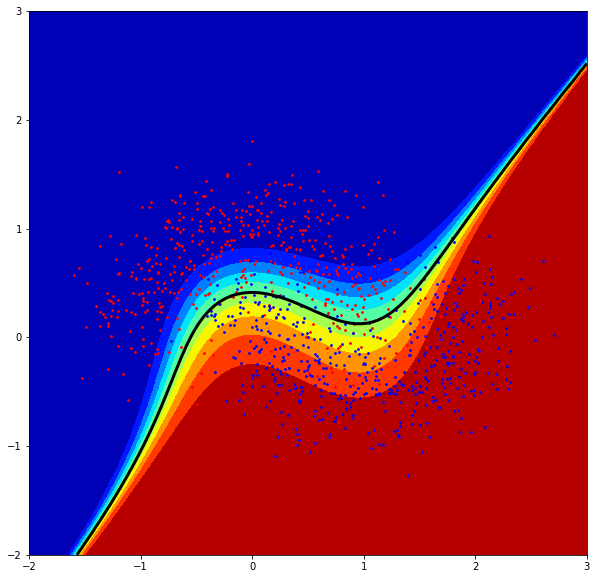

In [56]:
#
# Plotting the data
#
pl.figure(figsize=(10,10))
pl.xlim(-2, 3)
pl.ylim(-2, 3)
pl.contourf(xx, yy, z, cmap='jet', levels=10);
pl.contour(xx, yy, z, levels=[0, 0.5, 1], linewidths=3, colors='black');

plot_data();